## Analyses of Sequence Features that Determine Compaction

This notebook reproduces Fig. 1, 3, S3, S4, S6, and S10

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mdtraj as md
import warnings
import itertools
from ast import literal_eval
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d
import string
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

def plotEnergyMap(ax,dmap,label,vmin,vmax,cmap=plt.cm.bwr,
            xlabel='Residue #',ylabel='Residue #',ori='vertical', #error bar can be vertical or horizontal
            cbar=True,n_ticks=4): #to show color gradient
    im = ax.imshow(dmap,extent=[1, dmap.shape[0], 1, dmap.shape[0]], 
                 cmap=cmap,
                 origin='lower',alpha=1,aspect='equal',
                 vmin=vmin,vmax=vmax) #makes bars
    if cbar:
        divider = make_axes_locatable(ax)
        if ori == 'vertical':
            cax = divider.new_horizontal(size="5%", pad=.1)
        else:
            cax = divider.new_vertical(size="5%", pad=.15)
        f.add_axes(cax)
        cb = f.colorbar(im, cax=cax, orientation=ori,
                    label=r'{:s}'.format(label))
        cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
        cb.set_ticks([0,-3,-6,-9])
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    interval = round(dmap.shape[0]//n_ticks/10,0)*10
    ax.set_xticks([1, interval, interval*2, interval*3])
    ax.set_yticks([1, interval, interval*2, interval*3])
    return cb

dark_orange = mpl.cm.get_cmap('Oranges')(np.arange(0,1.1,.1))[-1]
dark_blue = mpl.cm.get_cmap('Blues')(np.arange(0,1.1,.1))[-1]
dark_green = mpl.cm.get_cmap('Greens')(np.arange(0,1.1,.1))[-1]

In [2]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)

# load data from five independent MD simulations of 33 sequences
df_replicas = pd.read_csv('md_simulations/data/replicas_data.csv',index_col=0)

df_replicas.nu_replicas = df_replicas.nu_replicas.apply(lambda x : literal_eval(x))
df_replicas.ete2_Rg2_replicas = df_replicas.ete2_Rg2_replicas.apply(lambda x : literal_eval(x))

df_replicas['protein_name'] = df_idrome.loc[df_replicas.index].protein_name
df_replicas['scd'] = df_idrome.loc[df_replicas.index].scd
df_replicas['kappa'] = df_idrome.loc[df_replicas.index].kappa
df_replicas['nu_single'] = df_idrome.loc[df_replicas.index].nu

In [3]:
df_idrome.query('nu < 0.33').nu.count()/df_idrome.shape[0]*100

0.42002800186679107

#### Fig. 1b

0.508


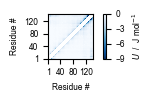

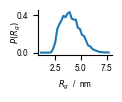

0.367


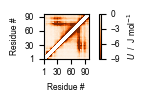

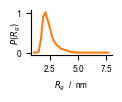

In [4]:
for name,n_ticks in zip(df_idrome[df_idrome.index.str.startswith('Q99457')].index,[4,3]):
    N = len(df_idrome.loc[name,'fasta'])
    print(df_idrome.loc[name].nu)
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_emap.csv.gz',index_col=0)
    
    if df_idrome.loc[name].nu <= 0.45:
        cmap = plt.cm.Oranges_r
        color = 'tab:orange'
    else:
        cmap = plt.cm.Blues_r
        color = 'tab:blue'
    
    f = plt.figure(figsize=(1.4,1))
    plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
    plotEnergyMap(plt.gca(),emap*1e3,'$U$  /  J mol$^{-1}$',-9,0,cmap=cmap,n_ticks=n_ticks)
    plt.tight_layout()
    plt.savefig('figs/'+name+'_emap.pdf',dpi=300)
    plt.show()
    
    f = plt.figure(figsize=(1.2,1))
    plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
    rg = np.load(f'md_simulations/data/replicas/{name:s}_rgarray.npy')
    bins = np.arange(1,8,.2)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(rg,bins=bins,density=True)
    
    plt.plot(x,h,lw=1.5,color=color)
    plt.xlabel('$R_g$  /  nm')
    
    plt.ylim(-h.max()/20,h.max()*1.05)
    plt.yticks([0,round(h.max(),1)])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylabel('$P(R_g)$',labelpad=-5)
    plt.tight_layout()
    plt.savefig('figs/'+name+'_rg.pdf',dpi=300)
    plt.show()

#### Fig. 1c

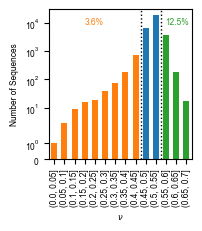

In [5]:
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(2,2.3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

N_tot = df_idrome.index.size

p_compact = df_idrome.query('nu <= .45').shape[0]/N_tot*100
p_expanded = df_idrome.query('nu > .55').shape[0]/N_tot*100
p_theta = 100-p_compact-p_expanded

intervals = pd.cut(df_idrome['nu'], np.arange(0, .71, .05))
sum_std = df_idrome['nu'].groupby(intervals).agg(['count'])
sum_std['count'].plot(rot=90, ax=ax, kind='bar', 
                      color=['tab:orange']*9+['tab:blue']*2+['tab:green']*3,width=.6)

ax.annotate(f'{p_compact:.1f}%',xy=(.25,.9),xycoords='axes fraction',color='tab:orange',fontsize=6)
ax.annotate(f'{p_expanded:.1f}%',xy=(.81,.9),xycoords='axes fraction',color='tab:green',fontsize=6)

ax.set_ylabel('Number of Sequences')
ax.set_xlabel(r'$\nu$')
ax.set_yscale('symlog')

ax.vlines([8.5,10.5],ymin=0,ymax=3e4,color='k',ls=':',lw=1)
ax.set_ylim(0,3e4)

plt.tight_layout()

fig.savefig('figs/fig1c.pdf',dpi=300)

#### Fig. 3

scd 43.63770707071475 182.93506030939312
kappa 0.7147122144672209 1.0
mean_lambda 0.4407435508688254 0.7527350612468828
fcr 0.723404255319149 0.9583333333333334
-28.192027953397822 182.93506030939312
0.0 1.0
0.0 0.9583333333333334


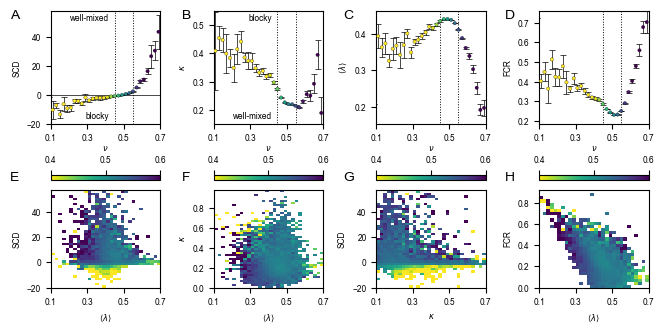

In [6]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(6.6,3.3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

features = ['scd','kappa','mean_lambda','fcr']
labels = ['SCD',r'$\kappa$',r'$\langle \lambda \rangle$','FCR']

bins = np.arange(0, .701, .02)
x = bins[:-1]+.01

for ax,feature,label in zip([ax1,ax2,ax3,ax4],features,labels):

    average = binned_statistic(df_idrome.nu,df_idrome[feature],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.nu,df_idrome[feature],statistic=se,
                                     bins=bins)[0]
    
    print(feature,np.nanmax(average),np.nanmax(df_idrome[feature]))

    ax.errorbar(x,average,yerr=standard_error,ms=0,marker='o',lw=0,zorder=0,
             elinewidth=.5,capsize=2,capthick=.5,label=label,color='k')
    
    ax.scatter(x,average,marker='o',
                    c=x,vmin=.4,vmax=.6,cmap=plt.cm.viridis_r,s=6,
                    edgecolor='k',lw=.2,zorder=10)

    ax.set_ylabel(label)
    ymin = np.nanmin(average)*.8
    ymax = np.nanmax(average)*1.05
    ax.vlines([.45,.55],ymin=-20,ymax=60,color='k',ls=':',lw=.7)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(.1,.7)
    ax.set_xticks(np.arange(.1,.71,.2))
    
    if label == 'SCD':
        ax.set_ylim(-20,58)
    
ax2.set_ylim(0.15,.55)

ax1.annotate('blocky',xy=(.53,.05),xycoords='axes fraction',fontsize=6,ha='right')
ax1.annotate('well-mixed',xy=(.53,.92),xycoords='axes fraction',fontsize=6,ha='right')

ax2.annotate('well-mixed',xy=(.53,.05),xycoords='axes fraction',fontsize=6,ha='right')
ax2.annotate('blocky',xy=(.53,.92),xycoords='axes fraction',fontsize=6,ha='right')


#############
interval = 2
decimal = 0

ybins = np.round(np.arange(df_idrome['scd'].min(),df_idrome['scd'].max(),interval),decimal)
xbins = np.round(np.arange(.1,.701,0.02),2)

xbins_center = xbins[:-1] + 0.02/2
ybins_center = ybins[:-1] + interval/2

h,_,_,_ = binned_statistic_2d(df_idrome['scd'].values,df_idrome.kappa.values,
            bins=[ybins,xbins],
            values=df_idrome.nu.values,statistic='median')
im = ax7.imshow(h, cmap=plt.cm.viridis_r,
                 origin='lower',alpha=1,extent=[xbins.min(),xbins.max(),
                                        ybins.min(),ybins.max()],
                 vmin=.4,vmax=.6,aspect='auto',interpolation='nearest')

ax7.set_ylim(-20,58)

ax7.set_xticks([.1,.3,.5,.7])
ax7.set_xticklabels([.1,.3,.5,.7])
ax7.set_xlim(.1,.7)
ax7.set_ylabel(label)

ax7.set_xlabel('$\\kappa$')
ax7.set_ylabel('SCD')

divider = make_axes_locatable(ax7)
cax = divider.new_vertical(size="{:.1f}%".format(5), pad=.1)
f.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='horizontal',ticks=[.4, .5, .6],
            label='$\\nu$')
cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')

#############

features = ['scd','kappa','fcr']
labels = ['SCD','$\\kappa$','FCR']
intervals = [2,.02,.03]
decimals = [0,2,2]

for ax,feature,label,interval,decimal in zip([ax5,ax6,ax8],features,labels,intervals,decimals):
    ybins = np.round(np.arange(df_idrome[feature].min(),df_idrome[feature].max(),interval),decimal)
    print(df_idrome[feature].min(),df_idrome[feature].max())
    xbins = np.round(np.arange(.1,.702,0.02),2)
    
    xbins_center = xbins[:-1] + 0.02/2
    ybins_center = ybins[:-1] + interval/2
    
    h,_,_,_ = binned_statistic_2d(df_idrome[feature].values,df_idrome.mean_lambda.values,
                bins=[ybins,xbins],
                values=df_idrome.nu.values,statistic='median')
    im = ax.imshow(h, cmap=plt.cm.viridis_r,
                     origin='lower',alpha=1,extent=[xbins.min(),xbins.max(),
                                                   ybins.min(),ybins.max()],
                     vmin=.4,vmax=.6,aspect='auto',interpolation='nearest')
    
    ax.set_xlabel(r'$\langle \lambda \rangle$')
    if label == 'SCD':
        ax.set_ylim(-20,58)
    
    ax.set_xticks([.1,.3,.5,.7])
    ax.set_xticklabels([.1,.3,.5,.7])
    ax.set_xlim(.1,.7)
    ax.set_ylabel(label)
        
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="{:.1f}%".format(5), pad=.1)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation='horizontal',ticks=[.4, .5, .6],
                label='$\\nu$')
    cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    
    
ax1.hlines(0,0,30,lw=.5,color='k')
    
f.text(0.01, .95, 'A', fontsize=10)
f.text(0.27, .95, 'B', fontsize=10)
f.text(0.515, .95, 'C', fontsize=10)
f.text(0.76, .95, 'D', fontsize=10)

f.text(0.01, .46, 'E', fontsize=10)
f.text(0.27, .46, 'F', fontsize=10)
f.text(0.515, .46, 'G', fontsize=10)
f.text(0.76, .46, 'H', fontsize=10)
    
plt.tight_layout(h_pad=.1)
plt.savefig('figs/fig3.pdf',dpi=300)

#### Fig. S3

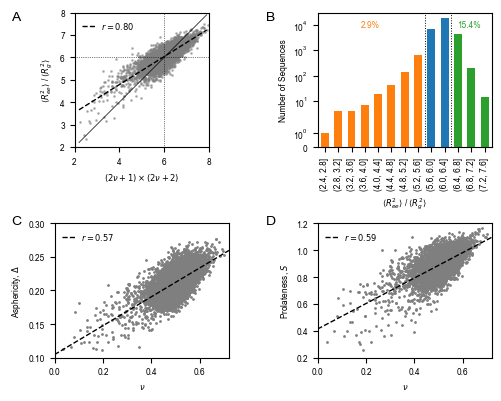

In [7]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(5,4))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

N_tot = df_idrome.index.size

df_idrome['ete2_Rg2_calc'] = (2*df_idrome.nu+1)*(2*df_idrome.nu+2)

ax1.plot(df_idrome.ete2_Rg2_calc,df_idrome.ete2_Rg2,ms=1,marker='o',lw=0,color='tab:gray',alpha=.5)
ax1.set_ylabel(r'$\langle R_{ee}^2 \rangle$ / $\langle R_g^2 \rangle$')
ax1.set_xlabel(r'$(2\nu+1)\times(2\nu+2)$')
x = np.linspace(2.2,7.9,100)
pr = pearsonr(df_idrome.ete2_Rg2_calc,df_idrome.ete2_Rg2)[0]
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_idrome.ete2_Rg2_calc,df_idrome.ete2_Rg2)
ax1.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label='$r={:.2f}$'.format(pr),zorder=4,color='k')
ax1.plot(x,x,lw=.5,zorder=4,color='k')

ax1.set_xlim(2,8)
ax1.set_ylim(2,8)
ax1.set_aspect('equal')

ax1.vlines(6,ymin=2,ymax=8,color='k',ls=':',lw=0.5)
ax1.hlines(6,xmin=2,xmax=8,color='k',ls=':',lw=0.5)

ax1.legend(frameon=False,loc='upper left',handlelength=1.5)

##########

p_compact = df_idrome.query('ete2_Rg2 <= 5.6').shape[0]/N_tot*100
p_expanded = df_idrome.query('ete2_Rg2 > 6.4').shape[0]/N_tot*100
p_theta = 100-p_compact-p_expanded

intervals = pd.cut(df_idrome['ete2_Rg2'], np.arange(2.4, 8, .4))
sum_std = df_idrome['ete2_Rg2'].groupby(intervals).agg(['count'])
sum_std['count'].plot(rot=90, ax=ax2, kind='bar', 
                      color=['tab:orange']*8+['tab:blue']*2+['tab:green']*3,width=.6)

ax2.annotate(f'{p_compact:.1f}%',xy=(.25,.895),xycoords='axes fraction',color='tab:orange',fontsize=6)
ax2.annotate(f'{p_expanded:.1f}%',xy=(.8,.895),xycoords='axes fraction',color='tab:green',fontsize=6)

ax2.set_ylabel('Number of Sequences')
ax2.set_xlabel(r'$\langle R_{ee}^2 \rangle$ / $\langle R_g^2 \rangle$')
ax2.set_yscale('symlog')

ax2.vlines([7.5,9.5],ymin=0,ymax=3e4,color='k',ls=':',lw=.7)
ax2.set_ylim(0,3e4)

##########

ax3.plot(df_idrome.nu,df_idrome.Delta,ms=1,marker='o',lw=0,color='tab:gray')
ax4.plot(df_idrome.nu,df_idrome.S,ms=1,marker='o',lw=0,color='tab:gray')
ax3.set_ylabel('Asphericity, $\Delta$')
ax4.set_ylabel('Prolateness, $S$')
ax3.set_xlabel('$\\nu$')
ax4.set_xlabel('$\\nu$')

x = np.linspace(0,0.72,100)

pr = pearsonr(df_idrome.nu,df_idrome.Delta)[0]
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_idrome.nu,df_idrome.Delta)
ax3.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label=f'$r={pr:.2f}$',zorder=4,color='k')
ax3.legend(frameon=False,handlelength=1.5)
ax3.set_xlim(0,.72)
ax3.set_ylim(.1,.3)
ax3.set_yticks([.1,.15,.2,.25,.3])

pr = pearsonr(df_idrome.nu,df_idrome.S)[0]
popt,_ = curve_fit(lambda x,a,b : a*x+b,df_idrome.nu,df_idrome.S)
ax4.plot(x,popt[0]*x+popt[1],ls='--',lw=1,label=f'$r={pr:.2f}$',zorder=4,color='k')
ax4.legend(frameon=False,handlelength=1.5)
ax4.set_xlim(0,.72)
ax4.set_ylim(0.2,1.2)

fig.text(0.02, .95, 'A', fontsize=10)
fig.text(0.53, .95, 'B', fontsize=10)
fig.text(0.02, .44, 'C', fontsize=10)
fig.text(0.53, .44, 'D', fontsize=10)

plt.tight_layout(w_pad=6)

fig.savefig('figs/figS3.png',dpi=300)

#### Fig. S4

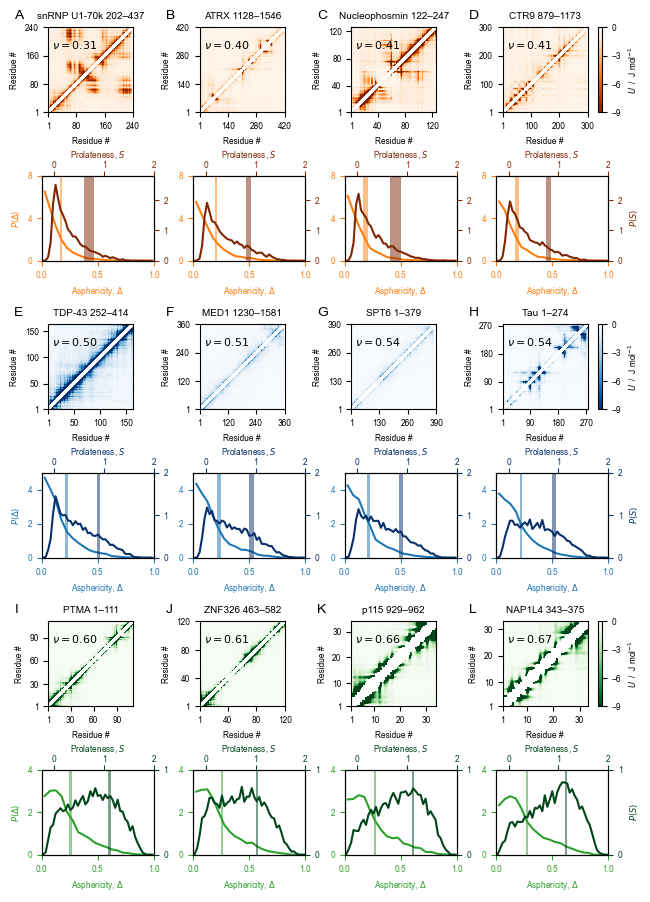

In [5]:
f, (r1,r2,r3,r4,r5,r6) = plt.subplots(6, 4, sharex=False, sharey=False, figsize=(6.6,9))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

proteins = ['P08621_202_437','P46100_1128_1546','P06748_122_247','Q6PD62_879_1173',
'Q13148_252_414','Q15648_1230_1581','Q7KZ85_1_274','P10636_1_379',
'P06454_1_111','Q5BKZ1_463_582','O60763_929_962','Q99733_343_375']

labels = ['snRNP U1-70k','ATRX','Nucleophosmin','CTR9','TDP-43','MED1',
 'SPT6','Tau','PTMA','ZNF326','p115','NAP1L4']

ax_map = np.concatenate([r1,r3,r5])
ax_a = np.concatenate([r2,r4,r6])

for i,name in enumerate(df_replicas.loc[proteins].sort_values('nu').index):
    emap = pd.read_csv(f'md_simulations/data/replicas/{name:s}_emap.csv.gz',index_col=0)
    
    if df_replicas.loc[name].nu <= 0.45:
        cmap = plt.cm.Oranges_r
        color = 'tab:orange'
        dark_color = dark_orange
    elif df_replicas.loc[name].nu > 0.55:
        cmap = plt.cm.Greens_r
        color = 'tab:green'
        dark_color = dark_green
    else:
        cmap = plt.cm.Blues_r
        color = 'tab:blue'
        dark_color = dark_blue
        
    n_ticks = 4 if i == 8 else 3
    
    cb = plotEnergyMap(ax_map[i],emap*1e3,'$U$  /  J mol$^{-1}$',-9,0,cmap=cmap,n_ticks=n_ticks)
    
    round_int = abs(int(np.log10(df_replicas.loc[name,'nu_err'])))+1
    
    nu = round(df_replicas.loc[name,'nu'],round_int)
    nu_err = round(df_replicas.loc[name,'nu_err'],round_int)
    
    ax_map[i].annotate('$\\nu={:.2f}$'.format(nu),
                      xy=(.05,.75),xycoords='axes fraction',fontsize=8)
    
    ax_map[i].annotate(string.ascii_uppercase[i],xy=(-.4,1.1),xycoords='axes fraction',fontsize=10)
    #ax_a[i].set_title('$\\nu={:#.3g}\pm{:#.3g}$'.format(nu,nu_err))
    
    if i in [0,4,8]:
        ax_a[i].set_ylabel('$P(\Delta)$',color=color)
    
    ax_a[i].set_xlabel('Asphericity, $\Delta$',color=color)
    ax_a[i].tick_params(axis='x',colors=color)
    ax_a[i].tick_params(axis='y',colors=color)
    ax_a[i].set_xlim(0,1)
    ax_a[i].set_xticks([0,.5,1])
    
    if i not in [3,7,11]:
        cb.remove() 
        
    s = np.load(f'md_simulations/data/replicas/{name:s}_Delta_array.npy')
    bins = np.arange(0,1.02,.05)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(s,bins=bins,density=True)
    ax_a[i].plot(x,h,lw=1.5,color=color)
    
    ax_s = inset_axes(ax_a[i], width="100%", height="100%", loc='lower left', borderpad=0)
    ax_s.patch.set_alpha(0)
    if i in [3,7,11]:
        ax_s.set_ylabel('$P(S)$',color=dark_color)
    s = np.load(f'md_simulations/data/replicas/{name:s}_S_array.npy')
    bins = np.arange(-.25,2.02,.05)
    x = bins[:-1]+(bins[1]-bins[0])/2.
    h,_ = np.histogram(s,bins=bins,density=True)
    ax_s.plot(x,h,lw=1.5,color=dark_color)
    ax_s.yaxis.set_ticks_position('right'); ax_s.yaxis.set_label_position('right')
    ax_s.xaxis.set_ticks_position('top'); ax_s.xaxis.set_label_position('top')
    ax_s.set_xlabel('Prolateness, $S$',color=dark_color,labelpad=2)  
    ax_s.tick_params(axis='x',colors=dark_color)
    ax_s.tick_params(axis='y',colors=dark_color)
    ax_s.set_xlim(-.25,2)
    ax_s.tick_params(axis='x', which='major', pad=1)
    
    if i < 4:
        ax_a[i].set_ylim(0,8)
        ax_a[i].set_yticks([0,4,8])
        ax_a[i].axvspan(df_replicas.loc[name,'Delta']-df_replicas.loc[name,'Delta_err'], 
                        df_replicas.loc[name,'Delta']+df_replicas.loc[name,'Delta_err'], 
                        alpha=0.5, lw=0.5, color='tab:orange')
    elif i > 7:
        ax_a[i].set_ylim(0,4)
        ax_a[i].set_yticks([0,2,4])
        ax_a[i].axvspan(df_replicas.loc[name,'Delta']-df_replicas.loc[name,'Delta_err'], 
                        df_replicas.loc[name,'Delta']+df_replicas.loc[name,'Delta_err'], 
                        alpha=0.5, lw=0.5, color='tab:green')
    else:
        ax_a[i].set_ylim(0,5)
        ax_a[i].set_yticks([0,2,4])
        ax_a[i].axvspan(df_replicas.loc[name,'Delta']-df_replicas.loc[name,'Delta_err'], 
                        df_replicas.loc[name,'Delta']+df_replicas.loc[name,'Delta_err'], 
                        alpha=0.5, lw=0.5, color='tab:blue')
        
    if i < 4:
        ax_s.set_ylim(0,2.8)
        ax_s.axvspan(df_replicas.loc[name,'S']-df_replicas.loc[name,'S_err'], 
                        df_replicas.loc[name,'S']+df_replicas.loc[name,'S_err'], alpha=0.5, 
                     lw=0.5, color=dark_orange)
    elif i > 7:
        ax_s.set_ylim(0,1)
        ax_s.set_yticks([0,1])
        ax_s.axvspan(df_replicas.loc[name,'S']-df_replicas.loc[name,'S_err'], 
                        df_replicas.loc[name,'S']+df_replicas.loc[name,'S_err'], alpha=0.5, 
                     lw=0.5, color=dark_green)
    else:
        ax_s.set_ylim(0,2)
        ax_s.set_yticks([0,1,2])
        ax_s.axvspan(df_replicas.loc[name,'S']-df_replicas.loc[name,'S_err'], 
                        df_replicas.loc[name,'S']+df_replicas.loc[name,'S_err'], alpha=0.5, 
                     lw=0.5, color=dark_blue)
        
    
    ax_map[i].set_title(labels[i]+' {:d}–{:d}'.format(
                        df_idrome.loc[name,'first'],df_idrome.loc[name,'last']))
    
plt.tight_layout()
plt.savefig('figs/figS4.pdf',dpi=300)

#### Fig. S6

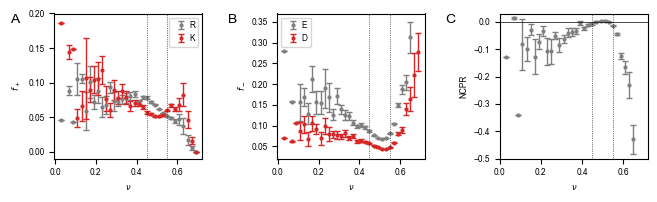

In [9]:
f, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(6.6,2))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

bins = np.arange(0, .701, .02)
x = bins[:-1]+.01

average = binned_statistic(df_idrome.nu,df_idrome['fR'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fR'],statistic=se,
                                     bins=bins)[0]
ax1.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label='R',color='tab:gray')
average = binned_statistic(df_idrome.nu,df_idrome['fK'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fK'],statistic=se,
                                     bins=bins)[0]
ax1.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,color='tab:red',label='K')

average = binned_statistic(df_idrome.nu,df_idrome['fE'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fE'],statistic=se,
                                     bins=bins)[0]
ax2.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label='E',color='tab:gray')
average = binned_statistic(df_idrome.nu,df_idrome['fD'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['fD'],statistic=se,
                                     bins=bins)[0]
ax2.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,color='tab:red',label='D')

average = binned_statistic(df_idrome.nu,df_idrome['ncpr'],bins=bins)[0]
standard_error = binned_statistic(df_idrome.nu,df_idrome['ncpr'],statistic=se,
                                     bins=bins)[0]
ax3.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,color='tab:gray',label='D')

ax1.set_ylabel('$f_+$')
ax1.set_xlabel('$\\nu$')
ax1.legend(frameon=True,loc='upper right',handletextpad=0)
ax1.vlines([.45,.55],ymin=-10,ymax=50,color='k',ls=':',lw=.5)
ax1.set_ylim(-.01,.2)

ax2.set_ylabel('$f_-$')
ax2.set_xlabel('$\\nu$')
ax2.legend(frameon=True,loc='upper left',handletextpad=0)
ax2.vlines([.45,.55],ymin=-10,ymax=50,color='k',ls=':',lw=.5)
ax2.set_ylim(0.02,.37)

ax3.set_ylabel('NCPR')
ax3.set_xlabel('$\\nu$')
ax3.hlines(0,0,1,lw=.5,color='k')
ax3.vlines([.45,.55],ymin=-10,ymax=50,color='k',ls=':',lw=.5)
ax3.set_ylim(-.5,.03)
ax3.set_xlim(0,.72)

f.text(0.02, .89, 'A', fontsize=10)
f.text(0.35, .89, 'B', fontsize=10)
f.text(0.68, .89, 'C', fontsize=10)

plt.tight_layout(w_pad=4)

f.savefig('figs/figS6.pdf',dpi=300)

In [20]:
df_idrome.query('nu > 0.45 and nu <= .55')['fR'].mean()*100,df_idrome.query('nu > 0.45 and nu <= .55')['fK'].mean()*100

(6.047620188795039, 5.346200290111869)

In [21]:
df_idrome.query('nu <= .45')['fR'].mean()*100,df_idrome.query('nu <= .45')['fK'].mean()*100

(7.873467596866261, 6.80186501970468)

#### Fig. S10

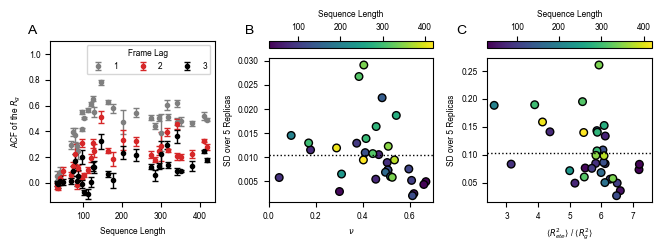

In [27]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(6.6,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})


ax1.errorbar(df_replicas.N,df_replicas.acf_rg_1,yerr=df_replicas.acf_rg_1_err,ms=3,marker='o',lw=0,
         elinewidth=1,capsize=2,capthick=1,label='1',color='tab:gray')
ax1.errorbar(df_replicas.N,df_replicas.acf_rg_2,yerr=df_replicas.acf_rg_2_err,ms=3,marker='o',lw=0,
         elinewidth=1,capsize=2,capthick=1,label='2',color='tab:red')
ax1.errorbar(df_replicas.N,df_replicas.acf_rg_3,yerr=df_replicas.acf_rg_3_err,ms=3,marker='o',lw=0,
         elinewidth=1,capsize=2,capthick=1,label='3',color='k')

scat = ax2.scatter(df_replicas.nu, df_replicas.nu_err, marker='o',
                    c=df_replicas.N,vmin=30,vmax=420,cmap=plt.cm.viridis,s=30,
                    edgecolor='k',zorder=2)
divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=0.1)
f.add_axes(cax)
cbar = plt.colorbar(scat, cax=cax, orientation='horizontal')
cbar.set_label('Sequence Length',labelpad=4)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

scat = ax3.scatter(df_replicas.ete2_Rg2, df_replicas.ete2_Rg2_err, marker='o',
                    c=df_replicas.N,vmin=30,vmax=420,cmap=plt.cm.viridis,s=30,
                    edgecolor='k',zorder=2)
divider = make_axes_locatable(ax3)
cax = divider.new_vertical(size="5%", pad=0.1)
f.add_axes(cax)
cbar = plt.colorbar(scat, cax=cax, orientation='horizontal')
cbar.set_label('Sequence Length',labelpad=4)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')


ax1.set_ylabel('ACF of the $R_g$')
ax1.set_xlabel('Sequence Length')
ax1.set_ylim(-.15,1.1)

ax2.hlines(df_replicas.nu_err.mean(),xmin=0,xmax=.7,color='k',ls=':',lw=1)
ax2.set_xlim(0,.7)

ax3.hlines(df_replicas.ete2_Rg2_err.mean(),xmin=2.4,xmax=7.6,color='k',ls=':',lw=1)
ax3.set_xlim(2.4,7.6)

ax1.legend(title='Frame Lag',ncol=3)
ax2.set_ylabel('SD over 5 Replicas')
ax2.set_xlabel('$\\nu$')

ax3.set_ylabel('SD over 5 Replicas')
ax3.set_xlabel(r'$\langle R_{ete}^2 \rangle$ / $\langle R_g^2 \rangle$')

f.text(0.04, .87, 'A', fontsize=10)
f.text(0.37, .87, 'B', fontsize=10)
f.text(0.69, .87, 'C', fontsize=10)

plt.tight_layout()
plt.savefig('figs/figS10.pdf')